## _*Hamiltonian and Gate Characterization*_ 


This notebook looks at characterization of Hamiltonian terms and at characterizing coherent gate errors

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.providers.aer.noise.errors.standard_errors import coherent_unitary_error
from qiskit.providers.aer.noise import NoiseModel

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from qiskit.ignis.characterization.hamiltonian import ZZFitter, zz_circuits

from qiskit.ignis.characterization.gates import (AmpCalFitter, ampcal_1Q_circuits, 
                                                 AngleCalFitter, anglecal_1Q_circuits, 
                                                 AmpCalCXFitter, ampcal_cx_circuits, 
                                                 AngleCalCXFitter, anglecal_cx_circuits)

# Measuring ZZ

**Theory**

The desired Hamiltonian (with no interactions) is 

$H=\sum_{i} \omega_i |1\rangle\langle1|$

However, in any practical system with coupling, there will unwanted interaction terms. One common term is a ZZ interaction, which we typically write out as an energy shift on the $|11\rangle$ state,

$H=\omega_0 (1-\sigma_{Z,0})/2 +\omega_1 (1-\sigma_{Z,1})/2 + \xi |11\rangle\langle 11|$

** Experiment **

The experiment to measure $\xi$ is to perform a Ramsey experiment on Q0 (H-t-H) and repeat the Ramsey with Q1 in the excited state. The difference in frequency between these experiments is the rate $\xi$

In [85]:
# ZZ rates are typically ~ 100kHz so we want Ramsey oscillations around 1MHz
# 12 numbers ranging from 10 to 1000, logarithmically spaced
# extra point at 1500
num_of_gates = np.arange(0,150,5)
gate_time = 0.1

# Select the qubits whose ZZ will be measured
qubits = [0]
spectators = [1]

# Generate experiments
circs, xdata, osc_freq = zz_circuits(num_of_gates, gate_time, qubits, spectators, nosc=2)

One of the features of the fitters are that we can split the circuits into multiple jobs and then give the results to the fitter as a list. Demonstrated below.

In [86]:
# Set the simulator with ZZ
zz_unitary = np.eye(4,dtype=complex)
zz_unitary[3,3] = np.exp(1j*2*np.pi*0.02*gate_time)
error = coherent_unitary_error(zz_unitary)
noise_model = NoiseModel()
noise_model.add_nonlocal_quantum_error(error, 'id', [0], [0,1])

# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 500
# For demonstration purposes split the execution into two jobs
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model).result()

ZZ Rate: 19.730088 kHz


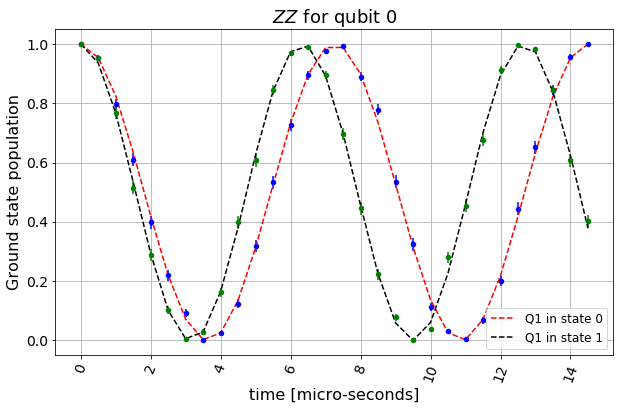

In [89]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_a = 1
initial_c = 0
initial_f = osc_freq 
initial_phi = -np.pi/20

fit = ZZFitter(backend_result1, xdata, qubits, spectators,
                   fit_p0=[initial_a, initial_f, initial_phi, initial_c],
                   fit_bounds=([-0.5, 0, -np.pi, -0.5],
                               [1.5, 2*osc_freq, np.pi, 1.5]))

fit.plot_ZZ(0, ax=plt.gca())
    
print("ZZ Rate: %f kHz"%(fit.ZZ_rate()[0]*1e3))
plt.show()

## Amplitude Error Characterization for Single Qubit Gates

Measure the amplitude error in the single qubit gates. Here this measures the error in the $\pi/2$ pulse.

In [2]:
qubits = [0]
circs, xdata = ampcal_1Q_circuits(10, qubits)

In [59]:
print(circs[2])

         ┌────────────────────┐┌───┐┌───┐┌─┐
q3_0: |0>┤ U2(1.5708,-1.5708) ├┤ X ├┤ X ├┤M├
         ├────────────────────┤└─┬─┘└─┬─┘└╥┘
q3_1: |0>┤         X          ├──■────■───╫─
         └────────────────────┘           ║ 
 c3_0: 0 ═════════════════════════════════╩═
                                            


In [107]:
# Set the simulator 
# Add a rotation error
err_unitary = np.zeros([2,2],dtype=complex)
angle_err = 0.1
for i in range(2):
    err_unitary[i,i] = np.cos(angle_err)
    err_unitary[i,(i+1) % 2] = np.sin(angle_err)
err_unitary[1,0] *= -1.0

error = coherent_unitary_error(err_unitary)
noise_model = NoiseModel()
noise_model.add_quantum_error(error, 'u2', qubits)

# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 500
# For demonstration purposes split the execution into two jobs
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model).result()

In [7]:
import importlib
#importlib.reload(qiskit.ignis.characterization.gates.fitters.AmpCal1QFitter)
%load_ext autoreload
from qiskit.ignis.characterization.gates import AmpCal1QFitter

Rotation Error on U2: -0.100171 rads


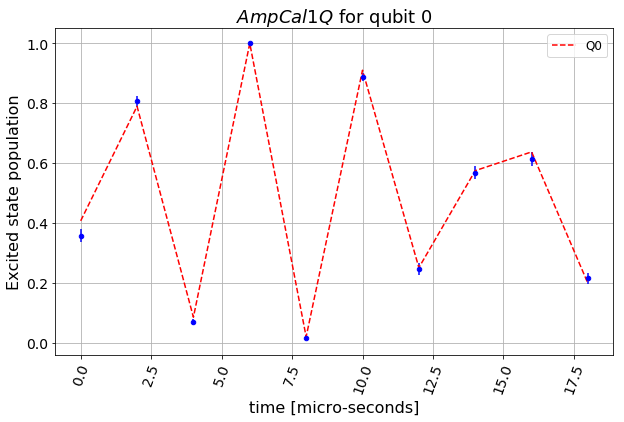

In [109]:
%matplotlib inline
%autoreload 2
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.1


fit = AmpCal1QFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot_err(0, ax=plt.gca())
    
print("Rotation Error on U2: %f rads"%(fit.angle_err()[0]))
plt.show()

## Angle Error Characterization for Single Qubit Gates

Measure the angle between the X and Y gates

In [61]:
qubits = [0]
circs, xdata = anglecal_1Q_circuits(10, qubits, angleerr=0.1)

In [63]:
#The U1 gates are added errors to test the procedure
print(circs[2])

         ┌─────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐»
q4_0: |0>┤ U2(0,0) ├┤ U1(0.2) ├┤ X ├┤ U1(-0.2) ├┤ Y ├┤ U1(0.2) ├┤ X ├»
         └─────────┘└─────────┘└───┘└──────────┘└───┘└─────────┘└───┘»
 c4_0: 0 ════════════════════════════════════════════════════════════»
                                                                     »
«      ┌──────────┐┌───┐┌─────────┐┌────────────────────┐┌─┐
«q4_0: ┤ U1(-0.2) ├┤ Y ├┤ U1(0.1) ├┤ U2(1.5708,-1.5708) ├┤M├
«      └──────────┘└───┘└─────────┘└────────────────────┘└╥┘
«c4_0: ═══════════════════════════════════════════════════╩═
«                                                           


In [218]:
# Set the simulator 
# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 1000
# For demonstration purposes split the execution into two jobs
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots).result()

Angle error between X and Y: 0.097169 rads


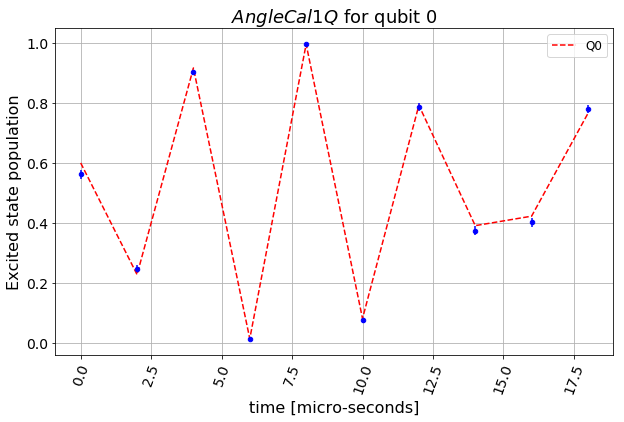

In [221]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AngleCal1QFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot_err(0, ax=plt.gca())
    
print("Angle error between X and Y: %f rads"%(fit.angle_err()[0]))
plt.show()

## Amplitude Error Characterization for CX Gates

This looks for a rotation error in the CX gate, ie., if the gate is actually $CR_x(\pi/2+\delta)$ measure $\delta$

In [51]:
qubits = [0]
controls = [1]
circs, xdata = ampcal_cx_circuits(15, qubits, controls)

In [57]:
print(circs[2])

         ┌────────────────────┐┌───┐┌───┐┌─┐
q3_0: |0>┤ U2(1.5708,-1.5708) ├┤ X ├┤ X ├┤M├
         ├────────────────────┤└─┬─┘└─┬─┘└╥┘
q3_1: |0>┤         X          ├──■────■───╫─
         └────────────────────┘           ║ 
 c3_0: 0 ═════════════════════════════════╩═
                                            


In [55]:
# Set the simulator 
# Add a rotation error on CX
# only if the control is in the excited state
err_unitary = np.eye(4,dtype=complex)
angle_err = 0.15
for i in range(2):
    err_unitary[2+i,2+i] = np.cos(angle_err)
    err_unitary[2+i,2+(i+1) % 2] = 1j*np.sin(angle_err)

error = coherent_unitary_error(err_unitary)
noise_model = NoiseModel()
noise_model.add_nonlocal_quantum_error(error, 'cx', [1,0], [0,1])

# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 1500
# For demonstration purposes split the execution into two jobs
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model).result()

Rotation Error on CX: 0.150354 rads


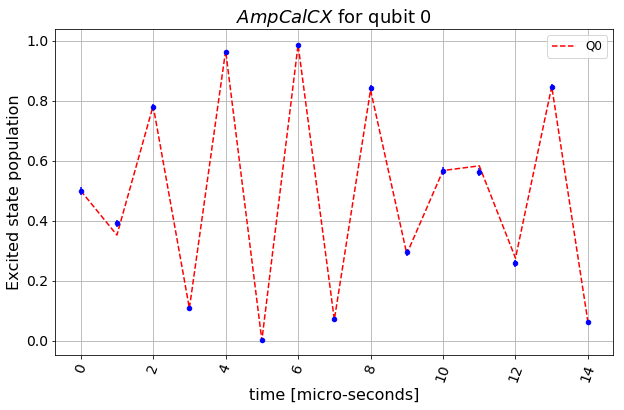

In [56]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AmpCalCXFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot_err(0, ax=plt.gca())
    
print("Rotation Error on CX: %f rads"%(fit.angle_err()[0]))
plt.show()

## Angle Error Characterization for CX Gates

Measure the angle error $\theta$ in the CX gate, i.e., $CR_{\cos(\theta)X+\sin(\theta)Y}(\pi/2)$ with respect to the angle of the single qubit gates.

In [72]:
qubits = [0]
controls = [1]
circs, xdata = anglecal_cx_circuits(15, qubits, controls, angleerr=0.1)

In [73]:
print(circs[2])

         ┌─────────┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐»
q7_0: |0>┤ U2(0,0) ├┤ U1(0.1) ├┤ X ├┤ U1(-0.1) ├┤ Y ├┤ U1(0.1) ├┤ X ├»
         ├─────────┤└─────────┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘»
q7_1: |0>┤    X    ├─────────────■────────────────────────────────■──»
         └─────────┘                                                 »
 c7_0: 0 ════════════════════════════════════════════════════════════»
                                                                     »
«      ┌──────────┐┌───┐┌────────────────────┐┌─┐
«q7_0: ┤ U1(-0.1) ├┤ Y ├┤ U2(1.5708,-1.5708) ├┤M├
«      └──────────┘└───┘└────────────────────┘└╥┘
«q7_1: ────────────────────────────────────────╫─
«                                              ║ 
«c7_0: ════════════════════════════════════════╩═
«                                                


In [74]:
# Set the simulator 
# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 1000
# For demonstration purposes split the execution into two jobs
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots).result()

Rotation Error on CX: 0.100192 rads


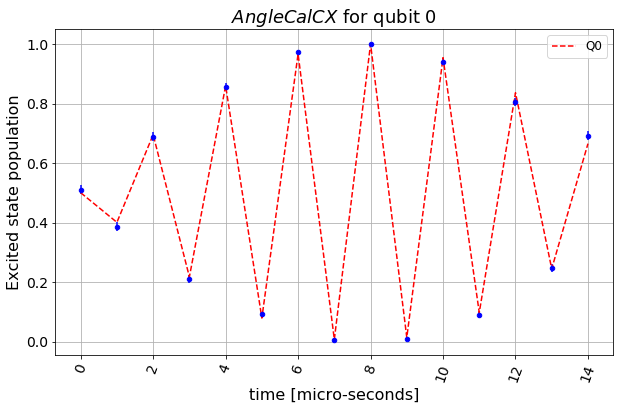

In [76]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AngleCalCXFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot_err(0, ax=plt.gca())
    
print("Rotation Error on CX: %f rads"%(fit.angle_err()[0]))
plt.show()